# Trabalho de implementação 1

Esse é o relatório e a implementação do __Trabalho de Implementação 1__ para a disciplina de __Fundamentos de Visão Computacional - INF01030__, ministrada pelo professor __Cláudio Jung__

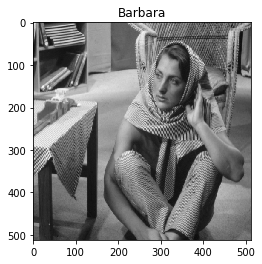

In [65]:
%matplotlib inline

# Imports
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Basic function to display B&W image
def display_image(img, title=''):
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.show()
    
# Load barbara image
barbara = cv2.cvtColor(cv2.imread('barbara.jpg'), cv2.COLOR_BGR2GRAY)
display_image(barbara, "Barbara")

# Configure Haar filters
C = np.array([1,  1]) / np.sqrt(2)
D = np.array([1, -1]) / np.sqrt(2)
F = np.array([ 1, 1]) / np.sqrt(2)
G = np.array([-1, 1]) / np.sqrt(2)
haar = [C, D, F, G]

## Questão 1

> Implemente uma transformada wavelet discreta (discrete wavelet transform, ou DWT) em 1D
  (direta e inversa) usando a noção de _filter banks_. O programa deve receber como entrada um
  sinal unidimensional, o nível máximo $J$ da decomposição, além dos 4 filtros necessários para a
  síntese/análise:
  
> * C: passa-baixas da decomposição
* D: passa-altas da decomposição
* F: passa-baixas da reconstrução
* G: passa-altas da reconstrução

> O programa deve gerar como saída o sinal suavizado $A_{2^j}[n]$, além dos sinais de detalhe $D_{2^j}[n]$,
  $j = 1, ..., J$. Dica: o comando $Wavelet$ do módulo $PyWavelets$ (https://pypi.org/project/PyWavelets) da linguagem Python fornece os coeficientes de várias famílias wavelet para teste.
  O módulo também fornece implementações para a DWT, mas você deverá implementar a sua
  transformada. No seu relatório, coloque resultados numéricos da sua rotina (coeficientes da DTW
  da transformada direta e o sinal reconstruído com a transformada inversa) aplicada ao seguinte sinal usando wavelets _Haar_   com $J = 2$: $x = [1, 2, -1, 3, 6, -2, -1, 3]$

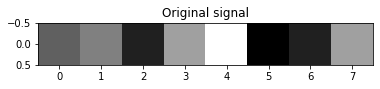

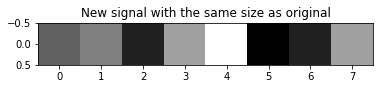

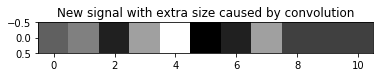

Original Signal was [ 1  2 -1  3  6 -2 -1  3] and new signal is [ 1.  2. -1.  3.  6. -2. -1.  3.  0.  0.  0.] ✔️


In [140]:
def wavelet_1d(signal, filters, J=2):
    '''
        Function which applies a wavelet transformation in a `signal` for `J` iterations at most.
        If the image can't handle `J` iterations, it will do the most it could.
        The `filters` array must be in the order `[C, D, F, G]`
    '''
    C, D, _, _ = filters

    # Transformation
    details = []
    for _ in range(J):
        # Convolution between signal and C for low-pass or D for high-pass
        y0 = np.convolve(signal, C)
        y1 = np.convolve(signal, D)
        
        # Downsampling, getting every other value
        v0 = y0[1::2]
        v1 = y1[1::2]
        
        # Passing to the next iteration
        signal = v0
        details.append(v1)
        
    return signal, details

def inversed_wavelet_1d(signal, filters, detail_signals=[]):
    _, _, F, G = filters
    
    # Inverse transformation
    for detail_signal in reversed(detail_signals):
        # As the original image may not have a side divided by 2, we could have a filter with 1 missing position at the end
        # We will fill it with 0 in that case
        fixed_detail_signal = np.concatenate(
            (detail_signal, np.array([0 for _ in range(len(signal) - len(detail_signal))])),
            axis=0,
        )
        
        v0 = signal
        v1 = fixed_detail_signal
        
        # Upsampling with the not-know values as 0
        u0 = v0.repeat(2)
        u0[1::2] = 0
        u1 = v1.repeat(2)
        u1[1::2] = 0
        
        # Convolution between the signals and F for low-pass and G for high-pass
        w0 = np.convolve(u0, F)
        w1 = np.convolve(u1, G)
        
        signal = w0 + w1
        
    return signal


signal = np.array([1, 2, -1, 3, 6, -2, -1, 3])
J = 2

soft_signal, detail_signals = wavelet_1d(signal, haar, J)
new_signal = inversed_wavelet_1d(soft_signal, haar, detail_signals)

display_image([signal], "Original signal")
display_image([new_signal[:len(signal)]], "New signal with the same size as original")
display_image([new_signal], "New signal with extra size caused by convolution")


print(f"Original Signal was {signal} and new signal is {new_signal} ✔️")

## Questão 2

> Implemente um transformada wavelet 2D (direta e inversa) separável, obtida através da aplicação da transformada 1D nas linhas e/ou colunas da imagem de entrada, conforme visto em aula.
Como saída, deverão ser geradas a imagem suavizada $A_{2^J}[n;m]$, além das imagens de detalhe
$D^{h}_{2^j}[nm]$, $D^{v}_{2^j}[n, m]$ e $D^{d}_{2^j}[n, m]$, para $j = 1, ..., J$. No seu relatório, mostre resultados visuais (imagens) da sua DTW 2D aplicada à imagem __barbara.jpg__, fornecida com o enunciado do trabalho
(a imagem é colorida, você deve primeiramente converter para tons de cinza). Use a _Haar_ com $J = 2$.

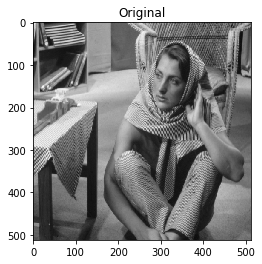

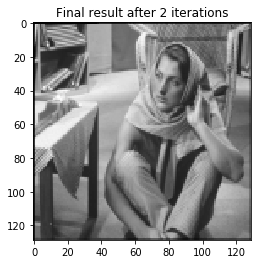

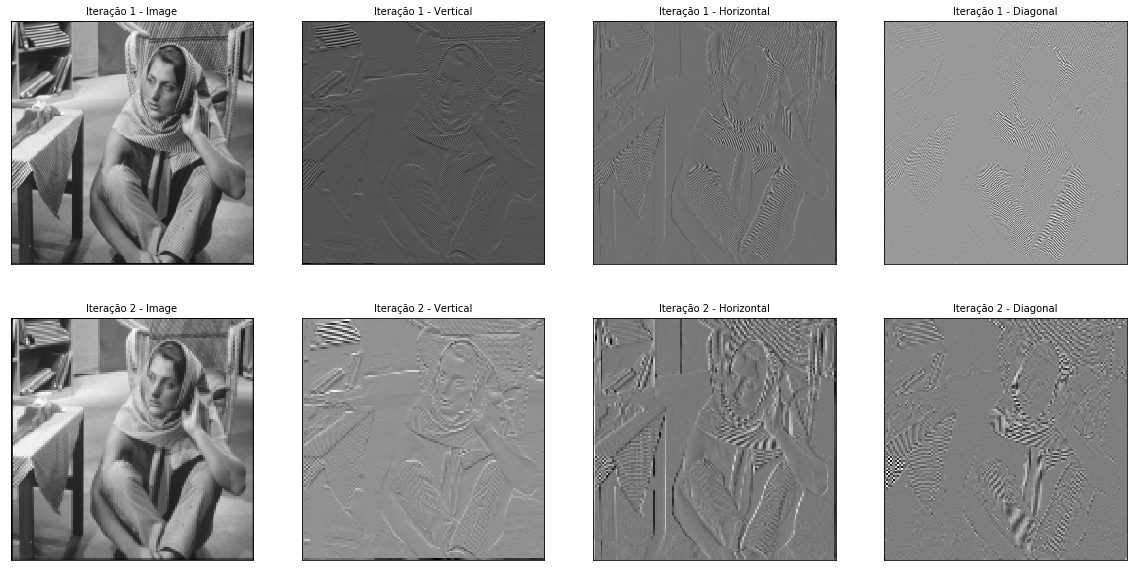

In [141]:
def wavelet_2d(image, filters, J=2):
    C, D, _, _ = filters
    
    details = []
    for _ in range(J):
        # Generating L and H first, to generate LL, LH, HL and HH after
        L = []
        H = []
        for idx, row in enumerate(image):
            y0 = np.convolve(row, C)
            y1 = np.convolve(row, D)
            if idx % 100 == 0 and False:
                print("row, idx, y0, y1", row, idx, y0, y1)
            
            L.append(y0)
            H.append(y1)
        
        # Convert in Numpy arrays to have the `transpose` method
        L = np.array(L)
        H = np.array(H)
        
        LL = []
        LH = []
        for column in L.T:
            y0 = np.convolve(column, C)
            y1 = np.convolve(column, D)
            
            LL.append(y0)
            LH.append(y1)
            
        HL = []
        HH = []
        for column in H.T:
            y0 = np.convolve(column, C)
            y1 = np.convolve(column, D)
            
            HL.append(y0)
            HH.append(y1)
            
        # Downscaling them, and fixing the orientation
        LL_2 = np.array(LL)[::2, ::2].T
        LH_2 = np.array(LH)[::2, ::2].T
        HL_2 = np.array(HL)[::2, ::2].T
        HH_2 = np.array(HH)[::2, ::2].T
        
        # Setting up to the next iteration
        image = LL_2
        details.append(np.array([LL_2, LH_2, HL_2, HH_2]))
        
    return image, details

# TODO: Fix this inverse
def inverse_wavelet_2d(signal, filters, detail_signals=[]):
    _, _, F, G = filters
    
    # Inverse transformation
    for detail_signal in reversed(detail_signals):
        LH, HL, HH = detail_signal
        LL = signal
        
        # Upsampling with the not known values as 0
        uLL = np.zeros(np.array(LL.shape) * 2)
        uLL[::2, ::2] = LL
        uLH = np.zeros(np.array(LH.shape) * 2)
        uLH[::2, ::2] = LH
        uHL = np.zeros(np.array(HL.shape) * 2)
        uHL[::2, ::2] = HL
        uHH = np.zeros(np.array(HH.shape) * 2)
        uHH[::2, ::2] = HH
         
        # Convolution in the upsampled value
        cuLL = np.convolve(uLL, F)
        cuLH = np.convolve(uLH, G)
        L = cuLL + cuLH
        
        cuHL = np.convolve(uHL, F)
        cuHH = np.convolve(uHH, G)
        H = cuHL + cuHH
        
        # Convolution in L and H to get the signal back
        cL = np.convolve(L, F)
        cH = np.convolve(H, G)
        I = cL + cH
        
        # Pass to the next iteration
        signal = I
        
    return signal

J = 2
image, details = wavelet_2d(barbara, haar, J)

display_image(barbara, "Original")
display_image(image, f"Final result after {J} iterations")

fig, axarr = plt.subplots(J,4, figsize=(20, 10))
titles = ["Image", "Vertical", "Horizontal", "Diagonal"]
for idx_detail, detail in enumerate(details):
    for idx_inside, img in enumerate(detail):
        axarr[idx_detail, idx_inside].imshow(img, interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_detail, idx_inside].set_title(f"Iteração {idx_detail + 1} - {titles[idx_inside]}", fontsize=10)
        axarr[idx_detail, idx_inside].set_xticks([])
        axarr[idx_detail, idx_inside].set_yticks([])
# image = inverse_wavelet_2d(image, haar, details)

## Questão 3

> Uma maneira de remover ruído em imagens é através de soft-thresholding dos coeficientes
wavelet, que consiste em "encolher" os coeficientes de detalhe para zero. Implemente um filtro
redutor de ruído aplicando a seguinte função para o soft-threshold dos coeficientes de detalhe
$T(x) = sgn(x)(|x| - t)_{+}$, onde $sgn(x)$ retorna o sinal de $x$, $t$ é um limiar ajustável, e $x_{+} = max(0, x)$.
Após o soft-thresholding dos coeficientes de detalhes, aplicar a transformada inversa para obter
a imagem filtrada. Nos seus testes, use a imagem _barbara.jpg_ (convertida para tons de cinza)
diretamente, e gere ao menos duas versões ruidosas (ruído Gaussiano aditivo com intensidades
variáveis). Você tem liberdade na escolha da família wavelet. Varie o valor de t e do número de
níveis $J$ na decomposição nos testes, e avalie os resultados obtidos no relatório.

> Dica: Use o módulo _opencv_ da linguagem _Python_ para manipulação e visualização das imagens.